---

#  Multi-Tool Visio Agent

This notebook demonstrates a complete **multi-tool visual reasoning workflow**:

- **Object Detection** with DETR  
- **OCR (Text Extraction)** with EasyOCR  
- **Image Captioning** with BLIP  
- **Automatic Planner** to decide which tools to run per query  
- **Annotated Results** displayed inline for clarity  

### Features:
- Handles **multiple images** and **multiple queries**  
- Combines object, text, and caption outputs into a concise, **user-friendly answer**  
- **Inline annotated images** resized for clarity  
- Designed for **easy adaptation** to larger datasets or custom queries  

>  Developed by **Hamayl Zahid** – showcasing advanced AI multi-modal reasoning in Python.

---



In [10]:
from google.colab import files
uploaded = files.upload()  # select multiple images


Saving download (1).jfif to download (1) (1).jfif
Saving JuiceBottleLabels.webp to JuiceBottleLabels (1).webp
Saving images (4).jfif to images (4).jfif
Saving Gemini_Generated_Image_ohrom4ohrom4ohro.png to Gemini_Generated_Image_ohrom4ohrom4ohro.png
Saving Gemini_Generated_Image_fka7onfka7onfka7.png to Gemini_Generated_Image_fka7onfka7onfka7 (1).png


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Device set to use cpu


### Image: download (1) (1).jfif

**Query:** How many bottles are there and what do their labels say?

[planner] {'detect': True, 'ocr': True, 'caption': False}
[annotate] saved annotated_0_download (1) (1).jfif


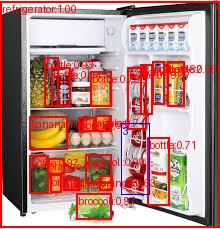

**Answer:** Detected: 1 banana, 1 refrigerator, 2 broccolis, 9 bottles, 3 apples, 3 oranges. Top detections: banana (score=1.00); refrigerator (score=1.00); broccoli (score=0.99). Detected text: '3'(0.32).

### Image: JuiceBottleLabels (1).webp

**Query:** Describe the scene in the image.

[planner] {'detect': False, 'ocr': False, 'caption': True}
[annotate] saved annotated_1_JuiceBottleLabels (1).webp


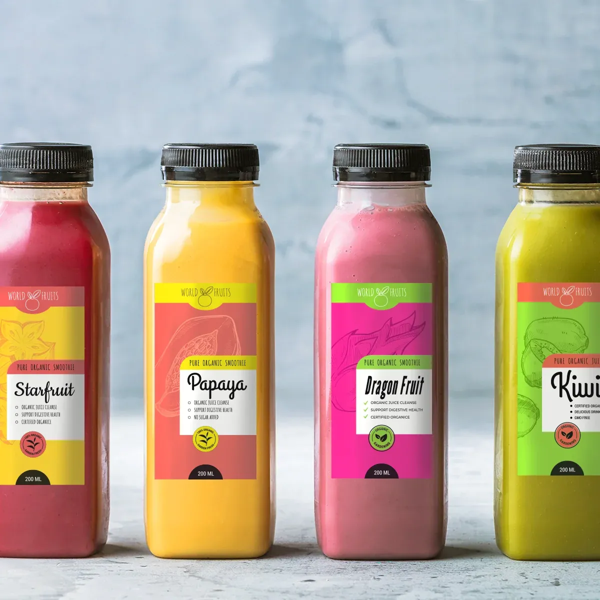

**Answer:** Scene caption: three bottles of juices with different flavors

### Image: images (4).jfif

**Query:** Describe the scene in the image.

[planner] {'detect': False, 'ocr': False, 'caption': True}
[annotate] saved annotated_2_images (4).jfif


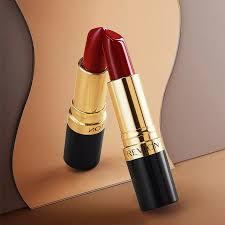

**Answer:** Scene caption: a red lipstick with a gold cap

### Image: Gemini_Generated_Image_ohrom4ohrom4ohro.png

**Query:** Describe the scene in the image.

[planner] {'detect': False, 'ocr': False, 'caption': True}
[annotate] saved annotated_3_Gemini_Generated_Image_ohrom4ohrom4ohro.png


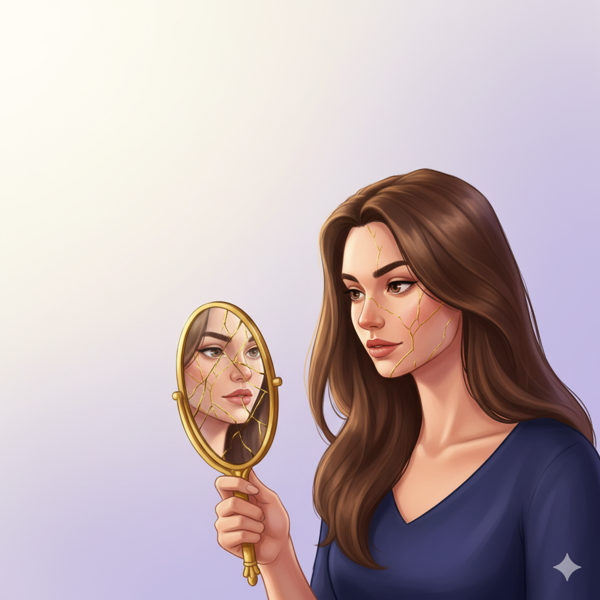

**Answer:** Scene caption: a woman looking at her face in a mirror

### Image: Gemini_Generated_Image_fka7onfka7onfka7 (1).png

**Query:** Describe the scene in the image.

[planner] {'detect': False, 'ocr': False, 'caption': True}
[annotate] saved annotated_4_Gemini_Generated_Image_fka7onfka7onfka7 (1).png


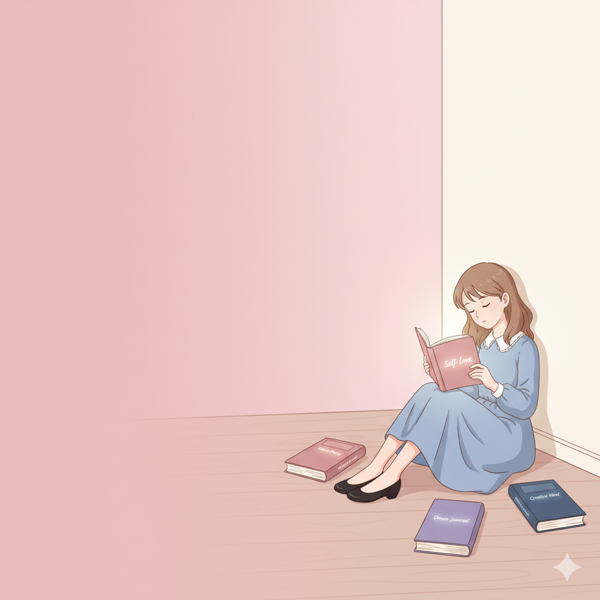

**Answer:** Scene caption: a girl sitting on the floor reading a book

In [11]:
# ----------------------------
# Multi-tool Visio Agent for multiple images (Colab ready)
# ----------------------------

from typing import List, Dict, Any
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from transformers import pipeline
import easyocr
from IPython.display import display, Markdown

# ----------------------------
# Tool wrappers
# ----------------------------
def load_pipelines(device=-1):
    od = pipeline("object-detection", model="facebook/detr-resnet-50", device=device)
    captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base", device=device)
    ocr_reader = easyocr.Reader(['en'], gpu=(device>=0))
    return od, captioner, ocr_reader

def detect_objects(pipeline_od, image: Image.Image, threshold: float = 0.5) -> List[Dict[str, Any]]:
    results = pipeline_od(image)
    processed = []
    for r in results:
        score = float(r.get("score", 0))
        if score < threshold:
            continue
        box = r.get("box")  # DETR returns list [xmin, ymin, xmax, ymax]
        if isinstance(box, dict):
            xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
        elif isinstance(box, (list, tuple)) and len(box) == 4:
            xmin, ymin, xmax, ymax = box
        else:
            continue
        processed.append({
            "label": r["label"],
            "score": score,
            "box": [float(xmin), float(ymin), float(xmax), float(ymax)]
        })
    processed.sort(key=lambda x: x["score"], reverse=True)
    return processed

def caption_image(pipeline_captioner, image: Image.Image) -> str:
    out = pipeline_captioner(image)
    if isinstance(out, list) and len(out) > 0:
        if isinstance(out[0], dict) and "generated_text" in out[0]:
            return out[0]["generated_text"].strip()
        elif isinstance(out[0], str):
            return out[0].strip()
    if isinstance(out, dict) and "generated_text" in out:
        return out["generated_text"].strip()
    return str(out)

def run_ocr(ocr_reader, image: Image.Image) -> List[Dict[str, Any]]:
    img_np = np.array(image.convert("RGB"))
    raw = ocr_reader.readtext(img_np)
    parsed=[]
    for bbox, text, prob in raw:
        xs = [pt[0] for pt in bbox]; ys=[pt[1] for pt in bbox]
        xmin, xmax = float(min(xs)), float(max(xs))
        ymin, ymax = float(min(ys)), float(max(ys))
        parsed.append({"text": text.strip(),"confidence": float(prob),"box":[xmin,ymin,xmax,ymax]})
    return parsed

# ----------------------------
# Helper functions
# ----------------------------
def iou(boxA, boxB):
    xA=max(boxA[0],boxB[0]); yA=max(boxA[1],boxB[1])
    xB=min(boxA[2],boxB[2]); yB=min(boxA[3],boxB[3])
    interW=max(0,xB-xA); interH=max(0,yB-yA); interArea=interW*interH
    if interArea==0: return 0.0
    boxAArea=(boxA[2]-boxA[0])*(boxA[3]-boxA[1])
    boxBArea=(boxB[2]-boxB[0])*(boxB[3]-boxB[1])
    return interArea/(boxAArea+boxBArea-interArea)

def map_ocr_to_detections(detections, ocrs, iou_thresh=0.1):
    for d in detections: d['ocr_texts']=[]
    for o in ocrs:
        best_match=None; best_iou=0
        for d in detections:
            val=iou(d['box'],o['box'])
            if val>best_iou: best_iou=val; best_match=d
        if best_iou>=iou_thresh and best_match: best_match['ocr_texts'].append((o['text'],o['confidence']))
    return detections

def simple_planner(query:str):
    q=query.lower()
    run_detect=any(k in q for k in ["count","how many","number of","detect","find","what bottles","what objects"])
    run_ocr=any(k in q for k in ["read","label","text","what does the label","ocr"])
    run_caption=any(k in q for k in ["describe","caption","what is happening","scene"])
    if not (run_detect or run_ocr or run_caption): run_detect=True; run_caption=True
    return {"detect":run_detect,"ocr":run_ocr,"caption":run_caption}

def synthesize_answer(detections, ocrs, caption, query):
    pieces=[]
    if detections:
        label_counts={d['label']:0 for d in detections}
        for d in detections: label_counts[d['label']]+=1
        label_summary=", ".join([f"{cnt} {lbl + ('s' if cnt>1 else '')}" for lbl,cnt in label_counts.items()])
        pieces.append(f"Detected: {label_summary}.")
        top3=detections[:3]
        top_str="; ".join([f"{d['label']} (score={d['score']:.2f})" for d in top3])
        pieces.append(f"Top detections: {top_str}.")
    if any(d.get('ocr_texts') for d in detections):
        mapped_texts=[]
        for d in detections:
            if d.get('ocr_texts'):
                texts=[t for t,c in d['ocr_texts']]
                mapped_texts.append(f"{d['label']}: "+" / ".join(texts))
        if mapped_texts: pieces.append("Labels read: "+ "; ".join(mapped_texts)+".")
    elif ocrs:
        topocr=sorted(ocrs,key=lambda x:x['confidence'],reverse=True)[:5]
        texts=[f"'{o['text']}'({o['confidence']:.2f})" for o in topocr]
        pieces.append("Detected text: "+", ".join(texts)+".")
    if caption: pieces.append("Scene caption: "+caption)
    final=" ".join(pieces)
    if len(final.strip())==0: final="No notable objects or text detected."
    return final

def annotate_and_save(image,detections,ocrs,out_path="annotated_output.jpg"):
    img=image.convert("RGB"); draw=ImageDraw.Draw(img)
    font=ImageFont.load_default()
    for d in detections:
        box=d['box']
        draw.rectangle([box[0],box[1],box[2],box[3]],outline="red",width=2)
        draw.text((box[0]+2,box[1]+2),f"{d['label']}:{d['score']:.2f}",fill="red",font=font)
    for o in ocrs:
        box=o['box']
        draw.rectangle([box[0],box[1],box[2],box[3]],outline="blue",width=1)
        draw.text((box[0]+2,box[1]+2),o['text'],fill="blue",font=font)
    img.save(out_path)
    print(f"[annotate] saved {out_path}")

# ----------------------------
# Display helper with resize
# ----------------------------
def display_resized(image_path, max_width=600):
    img = Image.open(image_path)
    w, h = img.size
    if w > max_width:
        ratio = max_width / w
        new_size = (int(w*ratio), int(h*ratio))
        img = img.resize(new_size)
    display(img)

# ----------------------------
# Batch agent with display
# ----------------------------
def run_agent_batch(image_paths:List[str], queries:List[str], device:int=-1):
    od, captioner, ocr_reader = load_pipelines(device)
    for i, image_path in enumerate(image_paths):
        query = queries[i] if i<len(queries) else queries[-1]
        display(Markdown(f"### Image: {image_path}"))
        display(Markdown(f"**Query:** {query}"))
        image = Image.open(image_path).convert("RGB")
        plan = simple_planner(query)
        print("[planner]", plan)
        detections, ocrs, caption = [], [], None
        if plan['detect']: detections = detect_objects(od,image,threshold=0.4)
        if plan['ocr']: ocrs = run_ocr(ocr_reader,image)
        if plan['caption']: caption = caption_image(captioner,image)
        if detections and ocrs: detections = map_ocr_to_detections(detections, ocrs)
        answer = synthesize_answer(detections, ocrs, caption, query)

        # annotate, save, and display nicely
        annotated_path = f"annotated_{i}_{image_path.split('/')[-1]}"
        annotate_and_save(image, detections, ocrs, out_path=annotated_path)
        display_resized(annotated_path, max_width=600)

        display(Markdown(f"**Answer:** {answer}"))
        print("\n" + "="*50 + "\n")

# ----------------------------
# Example usage after uploading multiple images
# ----------------------------
# uploaded = files.upload()  # Run this cell first to upload images

image_paths = list(uploaded.keys())  # filenames of uploaded images
queries = [
    "How many bottles are there and what do their labels say?",
    "Describe the scene in the image."
]  # can provide one query per image or reuse the same

run_agent_batch(image_paths, queries, device=-1)


---

#  Conclusion

This notebook demonstrates a **robust multi-tool visual AI agent** that can:

- Detect and count objects in images  
- Read and extract text from image regions (OCR)  
- Generate descriptive captions for any scene  
- Combine results into a **concise, user-friendly summary**  

### Key Takeaways:

1. **Multi-Modal Integration:** Combines object detection, OCR, and captioning seamlessly.  
2. **Automated Planning:** Queries determine which tools are applied, optimizing computation.  
3. **Interactive & Visual:** Annotated images displayed inline, making results easy to interpret.  
4. **Scalable:** Easily handles multiple images and queries in a batch.  

> This approach can be extended to **real-world applications** such as inventory management, document understanding, and automated content generation.  

---
